# <center><b> <em> Analyse </em> </b></center>

## <font color="green"> | - Import des Biblio et Dataframe</font>

In [19]:
import pandas as pd
import texthero as hero
from texthero import preprocessing,stopwords
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk import FreqDist
from nltk.stem import WordNetLemmatizer
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from wordcloud import WordCloud
from elasticsearch import Elasticsearch
from faker import Faker



In [20]:
# Read the XLSX file
data= pd.read_csv("../data/Emotion_final.csv")

## <font color="green"> || - Data Visualisation :</font>

In [21]:
data

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
21454,Melissa stared at her friend in dism,fear
21455,Successive state elections have seen the gover...,fear
21456,Vincent was irritated but not dismay,fear
21457,Kendall-Hume turned back to face the dismayed ...,fear


In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21459 entries, 0 to 21458
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Text     21459 non-null  object
 1   Emotion  21459 non-null  object
dtypes: object(2)
memory usage: 335.4+ KB


In [23]:
data["Emotion"].unique()

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'happy'],
      dtype=object)

In [24]:
data.isna().sum()

Text       0
Emotion    0
dtype: int64

In [25]:
# Répartition des textes par émotions
emotion_counts = data['Emotion'].value_counts()
emotion_counts

Emotion
happy       7029
sadness     6265
anger       2993
fear        2652
love        1641
surprise     879
Name: count, dtype: int64

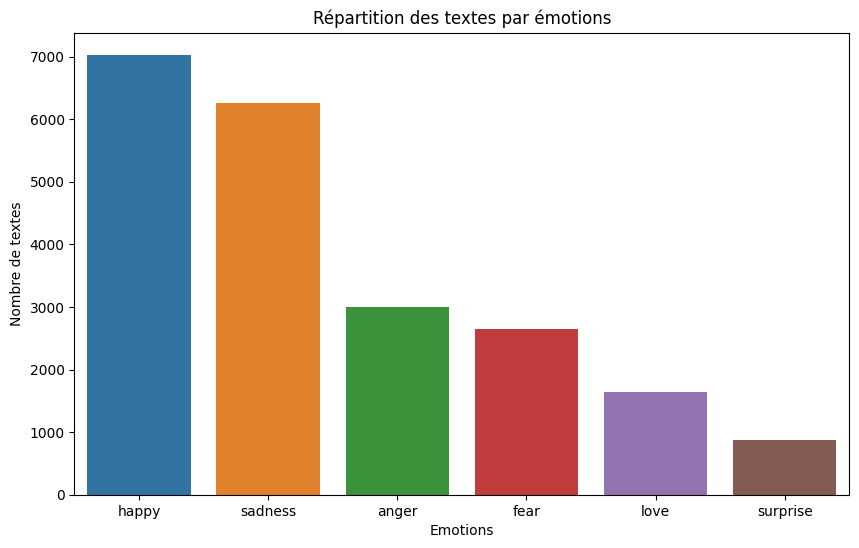

In [26]:
plt.figure(figsize=(10, 6))
sns.barplot(x=emotion_counts.index, y=emotion_counts.values)
plt.xlabel('Emotions')
plt.ylabel('Nombre de textes')
plt.title('Répartition des textes par émotions')
plt.show()

In [27]:
hero.top_words(data['Text'])


Text
i            32247
feel         13973
and          12699
to           11818
the          11672
             ...  
detoxing         1
scarecrow        1
wizard           1
flirtiing        1
surpris          1
Name: count, Length: 20011, dtype: int64

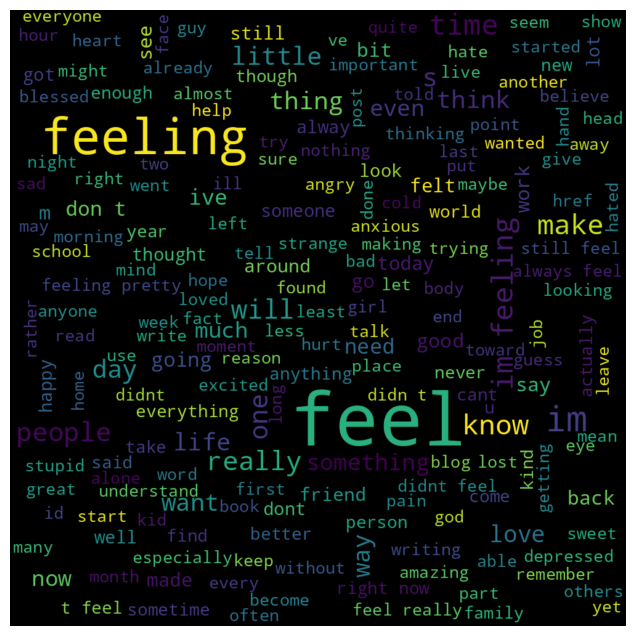

In [28]:
word= ' '.join([twts for twts in data['Text']])
clude= WordCloud(width=1000, height=1000, random_state= 21,min_font_size=15,max_font_size=119).generate(word)
plt.figure(figsize = (8,8))
plt.imshow(clude,interpolation='bilinear')
plt.axis('off')
plt.show()

## <font color="green"> ||| - Data Preprocessing</font>

In [29]:
default_stopwords = set(stopwords.DEFAULT)
custom_stopwords = ['ive','something','feel','feeling','feelings','like','im','know','get','would','time','little','even','one','life','people','think','bit','things','much','dont','make','going']
# Get the default English stopwords from texthero and add the custom stopwords
all_stopwords = default_stopwords.union(custom_stopwords)

# Prétraitement des données
custom_pipeline = [preprocessing.fillna,
                   preprocessing.lowercase,
                   preprocessing.remove_whitespace,
                   preprocessing.remove_diacritics,
                   preprocessing.remove_punctuation,
                   preprocessing.remove_urls,
                   preprocessing.remove_digits,
                   preprocessing.remove_brackets,
                   preprocessing.remove_angle_brackets,
                   preprocessing.remove_curly_brackets,
                   preprocessing.remove_square_brackets,
                   preprocessing.remove_punctuation,
                   preprocessing.remove_round_brackets,
                   preprocessing.remove_html_tags,
                   preprocessing.remove_whitespace,
                #    preprocessing.remove_stopwords]
                   lambda x: preprocessing.remove_stopwords(x, stopwords=all_stopwords)  # Apply remove_stopwords to each element
]



data['clean_text'] = hero.clean(data['Text'], pipeline=custom_pipeline)


In [30]:
hero.top_words(data['clean_text'])

clean_text
really        1201
want           811
still          759
could          627
love           620
              ... 
bernd            1
sportsbook       1
khatsii          1
mug              1
surpris          1
Name: count, Length: 19021, dtype: int64

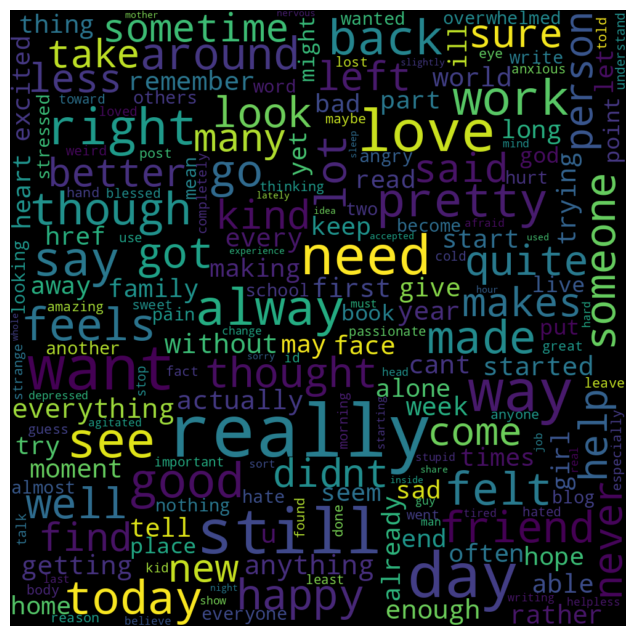

In [31]:
word= ' '.join([twts for twts in data['clean_text']])
clude= WordCloud(width=1000, height=1000, random_state= 21,min_font_size=15,max_font_size=119).generate(word)
plt.figure(figsize = (8,8))
plt.imshow(clude,interpolation='bilinear')
plt.axis('off')
plt.show()

In [32]:
data

,Text,Emotion,clean_text
0,i didnt feel humiliated,sadness,didnt humiliated
1,i can go from feeling so hopeless to so damned...,sadness,go hopeless damned hopeful around so...
2,im grabbing a minute to post i feel greedy wrong,anger,grabbing minute post greedy wrong
3,i am ever feeling nostalgic about the fireplac...,love,ever nostalgic fireplace still pr...
4,i am feeling grouchy,anger,grouchy
...,...,...,...
21454,Melissa stared at her friend in dism,fear,melissa stared friend dism
21455,Successive state elections have seen the gover...,fear,successive state elections seen governing pa...
21456,Vincent was irritated but not dismay,fear,vincent irritated dismay
21457,Kendall-Hume turned back to face the dismayed ...,fear,kendall hume turned back face dismayed coup


In [33]:
# Extraction des mots les plus courants pour chaque sentiment
top_words_by_emotion = {}
# for emotion in data['Emotion'].unique():
#     mask = data['Emotion'] == emotion
#     text = data[mask]['clean_text']
#     words = ' '.join(text).split()
#     word_freq = FreqDist(words)
#     top_words = [word for word, freq in word_freq.most_common(30) if word not in stopwords.words('english')]
#     top_words_by_emotion[emotion] = top_words
for emotion in data['Emotion'].unique():
    mask = data['Emotion'] == emotion
    text = data[mask]['clean_text']
    words = hero.tokenize(text).explode()
    word_freq = FreqDist(words)
    top_words = [word for word, freq in word_freq.most_common(30) if word not in stopwords.DEFAULT]
    top_words_by_emotion[emotion] = top_words

In [34]:
# Affichage des 30 mots les plus courants pour chaque sentiment
for emotion, words in top_words_by_emotion.items():
    print(f"Emotion: {emotion}")
    print(words)
    print()

Emotion: sadness
['really', 'still', 'want', 'day', 'back', 'way', 'could', 'pretty', 'right', 'always', 'go', 'love', 'felt', 'cant', 'sad', 'alone', 'bad', 'today', 'say', 'made', 'depressed', 'see', 'good', 'need', 'work', 'didnt', 'never', 'days', 'miserable', 'though']

Emotion: anger
['really', 'want', 'angry', 'could', 'way', 'offended', 'resentful', 'cold', 'still', 'irritable', 'cant', 'bothered', 'back', 'greedy', 'mad', 'insulted', 'irritated', 'need', 'pissed', 'violent', 'annoyed', 'hated', 'say', 'dissatisfied', 'fucked', 'rude', 'right', 'bitchy', 'cranky', 'frustrated']

Emotion: love
['love', 'really', 'sweet', 'loving', 'want', 'caring', 'passionate', 'sympathetic', 'liked', 'hot', 'tender', 'lovely', 'longing', 'loved', 'need', 'accepted', 'nostalgic', 'still', 'gentle', 'horny', 'naughty', 'romantic', 'blessed', 'supporting', 'loyal', 'could', 'supportive', 'beloved', 'feels', 'way']

Emotion: surprise
['amazed', 'impressed', 'curious', 'overwhelmed', 'funny', 'surp

In [35]:

nltk.download('wordnet')

# stopwords_list = ['feeling','feel','people','im','going', 'one', 'something', 'get','ive','back','day','know','time','way','thing','even','cant']
stopwords_list = ['feel','feeling','feelings','like','im','know','get','would','time','little','even','one','life','people','think','bit','things','much','dont','make','going']

# Initialiser le lemmatiseur WordNet
lemmatizer = WordNetLemmatizer()

# Supprimer les mots qui se ressemblent et garder la racine
for emotion, words in top_words_by_emotion.items():
    print(f"Emotion: {emotion}")
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words if word not in stopwords_list]
    unique_words = set(lemmatized_words)
    print(unique_words)
    print()


Emotion: sadness
{'made', 'depressed', 'day', 'today', 'right', 'felt', 'need', 'alone', 'always', 'cant', 'still', 'really', 'back', 'didnt', 'see', 'bad', 'say', 'could', 'miserable', 'good', 'work', 'way', 'never', 'pretty', 'love', 'though', 'go', 'want', 'sad'}

Emotion: anger
{'right', 'resentful', 'need', 'cant', 'still', 'really', 'bitchy', 'back', 'annoyed', 'violent', 'say', 'bothered', 'could', 'frustrated', 'cranky', 'rude', 'irritable', 'greedy', 'pissed', 'way', 'irritated', 'hated', 'cold', 'angry', 'insulted', 'offended', 'dissatisfied', 'fucked', 'want', 'mad'}

Emotion: love
{'loving', 'need', 'supportive', 'still', 'accepted', 'really', 'lovely', 'horny', 'hot', 'longing', 'blessed', 'romantic', 'could', 'sympathetic', 'way', 'naughty', 'passionate', 'love', 'supporting', 'loyal', 'loved', 'feel', 'beloved', 'liked', 'want', 'tender', 'sweet', 'gentle', 'caring', 'nostalgic'}

Emotion: surprise
{'surprised', 'curious', 'impressed', 'remember', 'always', 'strange', 's

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/apprenant/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## <font color="green"> IV - Métrique de proximité entre les sentiments </font>

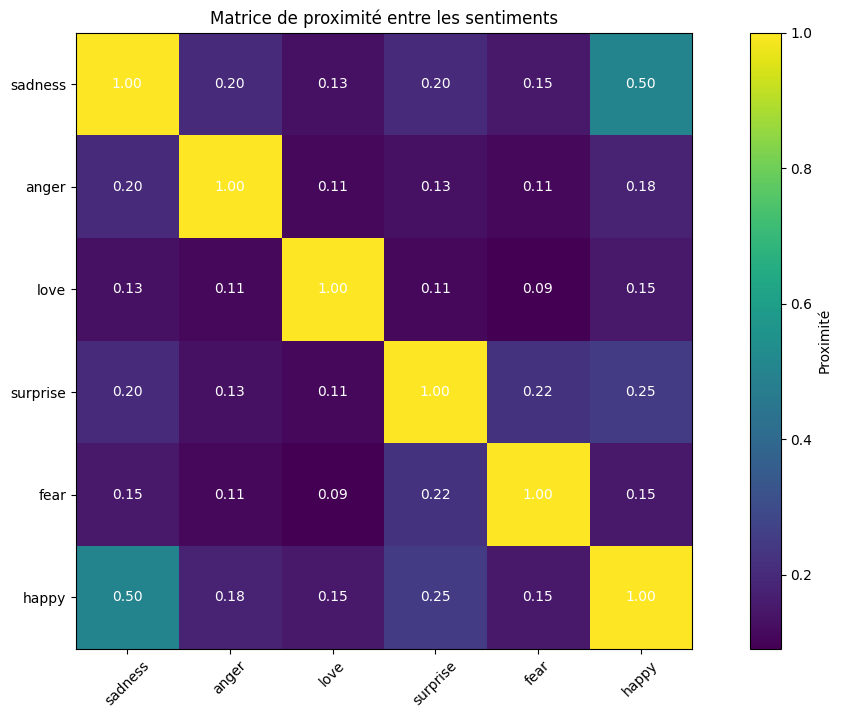

In [36]:

# Créer une matrice vide pour stocker la proximité entre les sentiments
proximity_matrix = np.zeros((len(top_words_by_emotion), len(top_words_by_emotion)))

# Calculer la proximité entre les sentiments
for i, (emotion1, top_words1) in enumerate(top_words_by_emotion.items()):
    for j, (emotion2, top_words2) in enumerate(top_words_by_emotion.items()):
        # Calculer le nombre de mots en commun entre les deux sentiments
        common_words = set(top_words1) & set(top_words2)
        
        # Stocker la proximité normalisée entre les sentiments dans la matrice
        proximity_matrix[i, j] = len(common_words) / len(set(top_words1) | set(top_words2))
        # Remark : En divisant le nombre de mots en commun par le nombre total de mots distincts, nous obtenons une valeur de proximité normalisée entre 0 et 1. 
        # Plus cette valeur est proche de 1, plus les sentiments sont similaires en termes de mots les plus courants.


# Afficher la matrice de proximité sous forme de heatmap avec annotations
plt.figure(figsize=(15, 8))
plt.imshow(proximity_matrix, cmap='viridis')

# Ajouter les annotations des valeurs sur chaque carré de la matrice
for i in range(len(top_words_by_emotion)):
    for j in range(len(top_words_by_emotion)):
        plt.text(j, i, f'{proximity_matrix[i, j]:.2f}', ha='center', va='center', color='white')

plt.xticks(np.arange(len(top_words_by_emotion)), top_words_by_emotion.keys(), rotation=45)
plt.yticks(np.arange(len(top_words_by_emotion)), top_words_by_emotion.keys())
plt.colorbar(label='Proximité')
plt.title('Matrice de proximité entre les sentiments')
plt.show()
